# Install and load all libraries

In [1]:
from fastai.vision.all import *

In [2]:
pd.set_option('display.max_rows', None)

# Data splitting based on clip name

Reading the dataframe from `CSV` file and removing the tangling column

In [4]:
clips_df = pd.read_csv('data/labels.csv')

# dropping dangling columns
clips_df = clips_df.loc[:, ~clips_df.columns.str.contains('^Unnamed')]
clips_df.head()

,clip_name,tools_present
0,clip_000000,"[needle driver, nan, needle driver, cadiere forceps]"
1,clip_000001,"[needle driver, nan, needle driver, cadiere forceps]"
2,clip_000002,"[needle driver, nan, needle driver, cadiere forceps]"
3,clip_000003,"[needle driver, nan, needle driver, cadiere forceps]"
4,clip_000004,"[needle driver, nan, needle driver, cadiere forceps]"


Standardising labels to reflect the output JSON dict() values by removing brackets (`[]`), quotes (`''`), hyphens (`-`), slashes (`\`) and also replacing underscore(`_`) in tools name for white spaces (` `) 


In [5]:
def clean_labels(c): return str([(i).strip().replace(" ", "_").replace("-", "_").replace("/", "_") for i in re.sub(r"[\[\]]",'',c).split(',')]).replace("'","").strip("'").strip("[").strip("]").replace(" ","")
clips_df['tools_present'] = clips_df['tools_present'].apply(clean_labels)

In [6]:
clips_df.head()

,clip_name,tools_present
0,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps"
1,clip_000001,"needle_driver,nan,needle_driver,cadiere_forceps"
2,clip_000002,"needle_driver,nan,needle_driver,cadiere_forceps"
3,clip_000003,"needle_driver,nan,needle_driver,cadiere_forceps"
4,clip_000004,"needle_driver,nan,needle_driver,cadiere_forceps"


We need to add a column for unique tools combination to allow intelligent data splitting where data from each split is lies in training and validation sets.

In [7]:
mapping_c = {k:v for v,k in enumerate(clips_df.tools_present.unique())}
clips_df['tools_comb_code'] = clips_df.tools_present.map(mapping_c)

Additionally, tools combination count is added to the dataframe

In [8]:
mapping_n = clips_df.tools_present.value_counts().to_dict(); mapping_n
clips_df['tools_comb_count'] = clips_df.tools_present.map(mapping_n)
print(len(clips_df))

24695


In [9]:
clips_df.head()

,clip_name,tools_present,tools_comb_code,tools_comb_count
0,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
1,clip_000001,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
2,clip_000002,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
3,clip_000003,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
4,clip_000004,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851


Exploring the video clip counts by each combination of tools.

In [10]:
clips_df.tools_present.value_counts()

needle_driver,nan,needle_driver,cadiere_forceps                                  6851
bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps                    5882
bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor                 2993
needle_driver,nan,needle_driver,prograsp_forceps                                 1836
cadiere_forceps,bipolar_forceps,nan,monopolar_curved_scissors                     965
force_bipolar,nan,monopolar_curved_scissors,cadiere_forceps                       775
bipolar_forceps,nan,vessel_sealer,cadiere_forceps                                 446
needle_driver,nan,needle_driver,grasping_retractor                                405
prograsp_forceps,cadiere_forceps,nan,permanent_cautery_hook_spatula               294
grasping_retractor,bipolar_forceps,nan,monopolar_curved_scissors                  260
cadiere_forceps,bipolar_forceps,nan,vessel_sealer                                 211
prograsp_forceps,bipolar_forceps,nan,permanent_cautery


There are eight tools combinations with just one video. 
> The `train test` split can't handle tools combinations with one video clip so we need to remove them from the dataframe for now. The `clip_df_ones` is created to temporary hold these videos for later frame extraction/splitting manually using custom logic.

In [11]:
clips_df_ones = clips_df[clips_df['tools_comb_count']==1]
clips_df.drop(clips_df_ones.index, inplace=True)
clips_df.reset_index(inplace=True,drop=True)
clips_df_ones.reset_index(inplace=True,drop=True)

Creating the logic to split the dataset into train test splits based on tools combination code column

In [12]:
def _test_splitter(f, items=None):
    "A basic set of condition a splitter must pass"
    items = ifnone(items, range_of(30))
    trn,val = f(items)
    assert 0<len(trn)<len(items)
    assert all(o not in val for o in trn)
    test_eq(len(trn), len(items)-len(val))
    # test random seed consistency
    test_eq(f(items)[0], trn)
    return trn, val

src = list(clips_df.index)
labels = list(clips_df.tools_comb_code)
test_size = 0.2

f = TrainTestSplitter(test_size=test_size, random_state=42, stratify=labels)
trn,val = _test_splitter(f, items=src)

print(len(clips_df), len(trn), len(val), len(trn)+len(val))
clips_df.head(10)

24687 19749 4938 24687


,clip_name,tools_present,tools_comb_code,tools_comb_count
0,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
1,clip_000001,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
2,clip_000002,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
3,clip_000003,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
4,clip_000004,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
5,clip_000005,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
6,clip_000006,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
7,clip_000007,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
8,clip_000008,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851
9,clip_000009,"needle_driver,nan,needle_driver,cadiere_forceps",0,6851


Adding the `valid` column to guide the intelligent `train test` split 

In [13]:
clips_df['valid']=False
for i in val: clips_df.loc[i,'valid']=True
clips_df.set_index('clip_name',inplace=True,drop=True)

Ensuring the data is split into `80-20` as requested 

In [14]:
round(clips_df.valid.value_counts()/len(clips_df)*100,2)

False    80.0
True     20.0
Name: valid, dtype: float64

### Preparing the images df from clips df and extrapolating the labels

In [15]:
images_df = pd.DataFrame([str(f) for f in get_image_files('data/train_images_c')],columns=['image_id'])
images_df['clip_name']=images_df['image_id'].map(parent_label)

def get_file_labels(c): 
    try:
        return clips_df.loc[c,'tools_present']
    except KeyError as err:
        try:
            return clips_df_ones.loc[c,'tools_present']
        except KeyError as err:
            return None
        
images_df['labels']=images_df['clip_name'].map(get_file_labels) 

images_df.head()

,image_id,clip_name,labels
0,data/train_images_c/clip_020717/01095.jpg,clip_020717,"cadiere_forceps,bipolar_forceps,nan,vessel_sealer"
1,data/train_images_c/clip_020717/00900.jpg,clip_020717,"cadiere_forceps,bipolar_forceps,nan,vessel_sealer"
2,data/train_images_c/clip_020717/00795.jpg,clip_020717,"cadiere_forceps,bipolar_forceps,nan,vessel_sealer"
3,data/train_images_c/clip_020717/01695.jpg,clip_020717,"cadiere_forceps,bipolar_forceps,nan,vessel_sealer"
4,data/train_images_c/clip_020717/00645.jpg,clip_020717,"cadiere_forceps,bipolar_forceps,nan,vessel_sealer"


In [16]:
total_files, total_rows = len(get_image_files('data/train_images_c')), len(images_df)
print(f'Totalfiles: {total_files} & total rows: {total_rows}')

Totalfiles: 2983454 & total rows: 2983454


In [17]:
assert total_files==total_rows

In [18]:
def get_file_valids(f): 
    try: 
        return clips_df.loc[f,'valid'] 
    except KeyError as err: 
        return

In [19]:
images_df['valid']=images_df['clip_name'].map(get_file_valids)

In [20]:
images_df.sample(n=10)

,image_id,clip_name,labels,valid
1665124,data/train_images_c/clip_023658/01080.jpg,clip_023658,"grasping_retractor,bipolar_forceps,nan,vessel_sealer",False
2642768,data/train_images_c/clip_011034/01320.jpg,clip_011034,"bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor",False
1497952,data/train_images_c/clip_014784/01335.jpg,clip_014784,"bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor",True
472902,data/train_images_c/clip_016760/00300.jpg,clip_016760,"bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor",False
1311574,data/train_images_c/clip_000258/01710.jpg,clip_000258,"bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps",False
97570,data/train_images_c/clip_014831/01725.jpg,clip_014831,"needle_driver,nan,needle_driver,grasping_retractor",False
919201,data/train_images_c/clip_015835/00090.jpg,clip_015835,"cadiere_forceps,bipolar_forceps,nan,clip_applier",False
2023611,data/train_images_c/clip_017178/00720.jpg,clip_017178,"bipolar_forceps,nan,needle_driver,grasping_retractor",False
2283493,data/train_images_c/clip_020161/00045.jpg,clip_020161,"bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor",False
553840,data/train_images_c/clip_008660/01215.jpg,clip_008660,"bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps",False


In [21]:
get_file_valids('clip_020717')

False

Verifying if the `clips_df_ones` files have valid status. This shall be `None` by default

In [22]:
clips_df_ones.clip_name

0    clip_004153
1    clip_006796
2    clip_007506
3    clip_011376
4    clip_014611
5    clip_016540
6    clip_018852
7    clip_018853
Name: clip_name, dtype: object

In [23]:
get_file_valids('clip_004153')

In [24]:
len(images_df.valid=='None')

2983454

In [25]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2983454 entries, 0 to 2983453
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   image_id   object
 1   clip_name  object
 2   labels     object
 3   valid      object
dtypes: object(4)
memory usage: 91.0+ MB


In [26]:
round(images_df.valid.value_counts()/len(images_df)*100)

False    80.0
True     20.0
Name: valid, dtype: float64

In [27]:
images_df.to_csv('data/images_df_raw.csv', index=False)

In [28]:
images_df=pd.read_csv('data/images_df_raw.csv', dtype={'image_id':str,'clip_name':str,'labels':str,'valid':str})

In [29]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2983454 entries, 0 to 2983453
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   image_id   object
 1   clip_name  object
 2   labels     object
 3   valid      object
dtypes: object(4)
memory usage: 91.0+ MB


In [30]:
images_df[images_df.clip_name=='clip_004153'].head()

,image_id,clip_name,labels,valid
2607399,data/train_images_c/clip_004153/01095.jpg,clip_004153,NaN,NaN
2607400,data/train_images_c/clip_004153/00900.jpg,clip_004153,NaN,NaN
2607401,data/train_images_c/clip_004153/00795.jpg,clip_004153,NaN,NaN
2607402,data/train_images_c/clip_004153/01695.jpg,clip_004153,NaN,NaN
2607403,data/train_images_c/clip_004153/00645.jpg,clip_004153,NaN,NaN


Manually splitting the images of `clip_df_ones` videos and fixing their labvels and valids `None` error as shown above.

In [31]:
for clip in clips_df_ones.clip_name:
    fs = get_image_files(f'data/train_images_c/{clip}')
    split = int(len(fs)*0.8)
    trn_fs, val_fs = fs[:split], fs[split:]
    for f in trn_fs:
        images_df.loc[images_df['image_id'] == str(f),['labels','valid']]=[clips_df_ones[clips_df_ones.clip_name==clip].tools_present.item(),False]
    for f in val_fs:
        images_df.loc[images_df['image_id'] == str(f),['labels','valid']]=[clips_df_ones[clips_df_ones.clip_name==clip].tools_present.item(),True]
    

In [32]:
images_df[images_df.clip_name=='clip_004153']

,image_id,clip_name,labels,valid
2607399,data/train_images_c/clip_004153/01095.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607400,data/train_images_c/clip_004153/00900.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607401,data/train_images_c/clip_004153/00795.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607402,data/train_images_c/clip_004153/01695.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607403,data/train_images_c/clip_004153/00645.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607404,data/train_images_c/clip_004153/01155.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607405,data/train_images_c/clip_004153/01770.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607406,data/train_images_c/clip_004153/00840.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607407,data/train_images_c/clip_004153/01035.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False
2607408,data/train_images_c/clip_004153/00855.jpg,clip_004153,"cadiere_forceps,force_bipolar,nan,bipolar_forceps",False


Fixing labels of blank images containing no tools. These can be used to adjust labels to `none, none, none, none`.
- Only run this code once as it takes time to complete

In [33]:
# blank_images=[]
# fs = get_image_files('data/train_images_c')
# i=1;
# for f in fs:
#     img=PILImage.create(f)
#     extrema = img.convert("L").getextrema()
#     if extrema == (0,0):
#         blank_images.append(f)
#     i+=1;
#     if i%50000==0: print(i) 

# with open("data/blank_images.pkl", "wb") as f:
#     pickle.dump(blank_images, f, protocol=pickle.HIGHEST_PROTOCOL)

# len(blank_images)

In [34]:
blank_images = pickle.load(open("data/blank_images.pkl", 'rb'))

In [35]:
blank_images = sorted(blank_images);len(blank_images)

14334

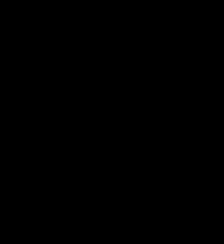

In [37]:
f=random.randint(1,len(blank_images))
PILImage.create(blank_images[f]).resize((224,244))

In [38]:
for f in blank_images:
    images_df.loc[images_df['image_id'] == str(f),'labels']='blank,blank,blank,blank'

In [39]:
images_df.labels.value_counts()

needle_driver,nan,needle_driver,cadiere_forceps                                  819944
bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps                    710343
bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor                 357833
needle_driver,nan,needle_driver,prograsp_forceps                                 221545
cadiere_forceps,bipolar_forceps,nan,monopolar_curved_scissors                    115839
force_bipolar,nan,monopolar_curved_scissors,cadiere_forceps                       93666
bipolar_forceps,nan,vessel_sealer,cadiere_forceps                                 53802
needle_driver,nan,needle_driver,grasping_retractor                                48343
prograsp_forceps,cadiere_forceps,nan,permanent_cautery_hook_spatula               35546
grasping_retractor,bipolar_forceps,nan,monopolar_curved_scissors                  30805
cadiere_forceps,bipolar_forceps,nan,vessel_sealer                                 25505
prograsp_forceps,bipolar_forceps

In [40]:
images_df.sort_values(by='clip_name', inplace=True)
images_df.reset_index(inplace=True, drop=True)
round(images_df['valid'].value_counts()/len(images_df)*100)

False    80.0
True     20.0
False     0.0
True      0.0
Name: valid, dtype: float64

In [41]:
images_df.to_csv('data/images_df_final.csv', index=False)

In [42]:
images_df=pd.read_csv('data/images_df_final.csv', dtype={'image_id':str,'clip_name':str,'labels':str})

In [43]:
round(images_df['valid'].value_counts()/len(images_df)*100,2)

False    80.0
True     20.0
Name: valid, dtype: float64

In [44]:
images_df.sample(n=10)

,image_id,clip_name,labels,valid
2793548,data/train_images_c/clip_023146/00600.jpg,clip_023146,"needle_driver,nan,needle_driver,prograsp_forceps",True
2012499,data/train_images_c/clip_016673/01350.jpg,clip_016673,"needle_driver,nan,needle_driver,prograsp_forceps",False
474148,data/train_images_c/clip_003927/01440.jpg,clip_003927,"bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps",True
165243,data/train_images_c/clip_001367/01140.jpg,clip_001367,"bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps",False
2183477,data/train_images_c/clip_018088/00480.jpg,clip_018088,"needle_driver,nan,needle_driver,cadiere_forceps",False
2478718,data/train_images_c/clip_020536/01185.jpg,clip_020536,"needle_driver,nan,needle_driver,cadiere_forceps",False
1709774,data/train_images_c/clip_014163/00285.jpg,clip_014163,"bipolar_forceps,nan,monopolar_curved_scissors,grasping_retractor",False
2779297,data/train_images_c/clip_023028/01605.jpg,clip_023028,"bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps",False
2506004,data/train_images_c/clip_020762/01515.jpg,clip_020762,"prograsp_forceps,cadiere_forceps,nan,permanent_cautery_hook_spatula",False
342869,data/train_images_c/clip_002839/01500.jpg,clip_002839,"bipolar_forceps,nan,monopolar_curved_scissors,cadiere_forceps",False


### Testing datablock to read from images df

There are eight folder with just one label so our train test splitter can't assign it to either training or validation sets. So the images from those folder will have null validation value. We need to delete those rows from our dataframe

In [68]:
len(images_df)

2983454

In [69]:
# images_df.dropna(subset=['valid'], inplace=True)
# images_df.reset_index(inplace=True, drop=True)
# len(images_df)

FastAI splitter can't handle non-numeric indexes for a dataframe to perform splitting. So instead of search the given string and looking it up by a key, I adopted the querying the table directly with pandas query function

Creating a datablock that can read from the dataframe

In [70]:
def get_x(r): return r['image_id']
def get_y(r): return r['labels']
def splitter(df):
    train = images_df.index[~images_df['valid']].to_list()
    valid = images_df.index[images_df['valid']].to_list()
    return train, valid

In [79]:
dblock=DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=ColReader('image_id'),
                 get_y=ColReader('labels'),
                 splitter=splitter,
                 item_tfms=Resize((320,640), method='squish')
)


In [80]:
dls = dblock.dataloaders(images_df)

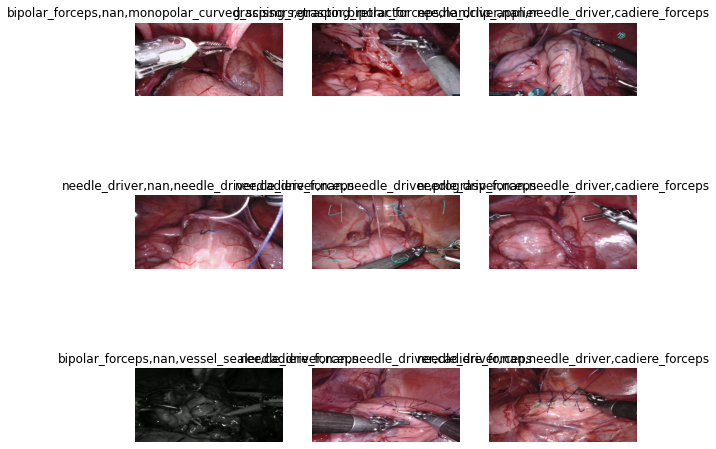

In [81]:
dls.show_batch()